In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score

import warnings
warnings.filterwarnings('ignore')

# Importing Classifier Modules
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.preprocessing import StandardScaler

In [3]:
os.getcwd()

'C:\\Users\\Devdutt\\Desktop\\0Data Mining\\Assignment_3_23-1\\Assignment_3'

In [4]:
titanic_train = pd.read_csv('Titanic Survival\\train.csv')

In [5]:
titanic_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
titanic_train.shape

(891, 12)

In [7]:
titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### Null percentage of columns

In [8]:
((titanic_train.isnull().sum()*100)/titanic_train.shape[0]).round(2)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

#### There are 3 columns with missing values:
* Age
* Cabin
* Embarked

### Handling Nulls

#### Imputing "Age" with mean

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


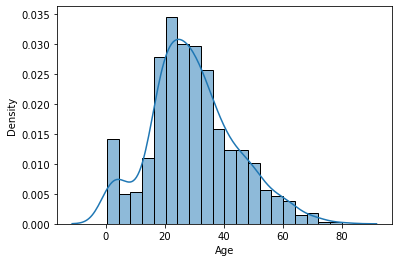

In [9]:
print(titanic_train['Age'].describe())

sns.histplot(titanic_train[titanic_train['Age'].notnull()]['Age'],
             kde = True, stat="density", kde_kws=dict(cut=3))
plt.show()

In [10]:
titanic_train['Age'].fillna(int(titanic_train['Age'].mean()), inplace=True)

#### Dropping column "Cabin" since it is ~77% null values

In [11]:
titanic_train['Cabin'].nunique()

147

In [12]:
titanic_train.drop(columns = ['Cabin'], inplace = True)

#### Replacing "Embarked" missing values with Mode

In [13]:
round(titanic_train['Embarked'].value_counts(normalize = True, dropna=False)*100,2)

S      72.28
C      18.86
Q       8.64
NaN     0.22
Name: Embarked, dtype: float64

In [14]:
titanic_train['Embarked'].fillna('S', inplace=True)

#### Dropping "PassengerId", "Name", and "Ticket" columns

In [15]:
titanic_train.drop(columns = ['PassengerId','Name','Ticket'], inplace = True)

In [16]:
titanic_train.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C


### Exploratory Data Analysis and Feature Mining

#### Pclass (Ticket class)

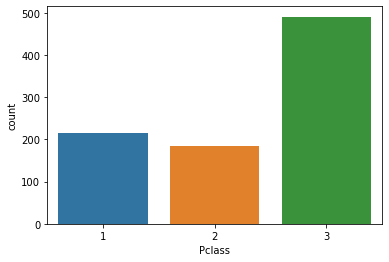

In [17]:
sns.countplot(x='Pclass',data = titanic_train)
plt.show()

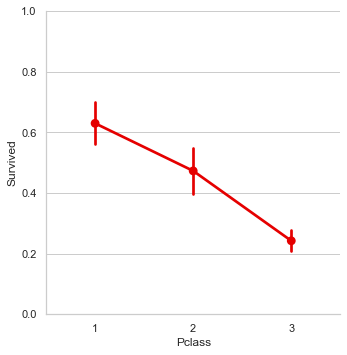

In [18]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=titanic_train, x_vars=['Pclass'], y_vars='Survived', height=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
g.set(ylim=(0, 1))
plt.show()

1st class passengers' survival rate is higher.

#### Sex

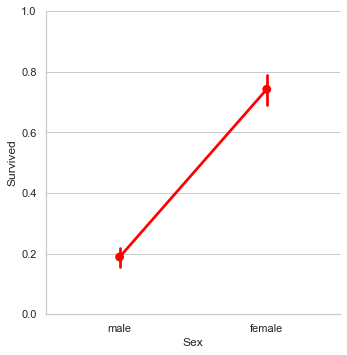

In [19]:
h = sns.PairGrid(data=titanic_train, x_vars=['Sex'], y_vars='Survived', height=5)
h.map(sns.pointplot, color="red")
h.set(ylim=(0, 1))
plt.show()

Female survival rate is higher.

#### Combining SibSp and Parch to a single variable "family"
SibSp = # of siblings/spouses aboard the Titanic

Parch = # of parents/children aboard the Titanic

In [20]:
titanic_train['family'] = titanic_train['SibSp'] + titanic_train['Parch']

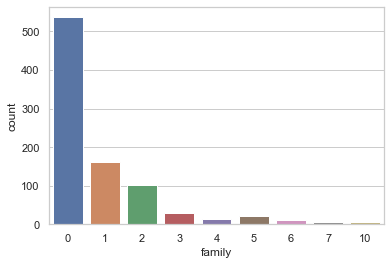

In [21]:
sns.countplot(x='family',data = titanic_train)
plt.show()

#### We observe that majority of the passengers are alone and make another column: "is_alone"

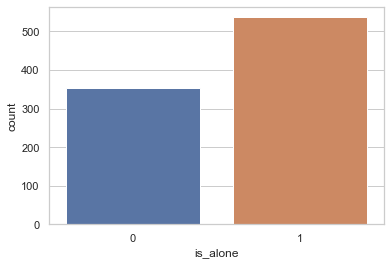

In [22]:
titanic_train['is_alone'] = titanic_train['family'].apply(lambda x: 1 if x == 0 else 0)
sns.countplot(x='is_alone',data = titanic_train)
plt.show()

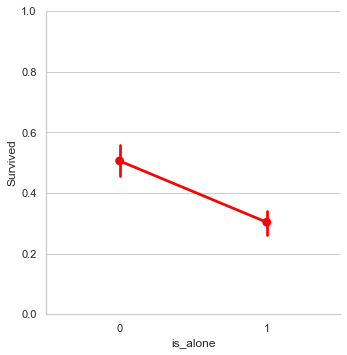

In [23]:
h = sns.PairGrid(data=titanic_train, x_vars=['is_alone'], y_vars='Survived', height=5)
h.map(sns.pointplot, color="red")
h.set(ylim=(0, 1))
plt.show()

People with no family members have a lower survival rate. 

#### Making a "is_child" column from the Age column

In [24]:
titanic_train['is_child'] = titanic_train['Age'].apply(lambda x: 1 if x <= 15 else 0)

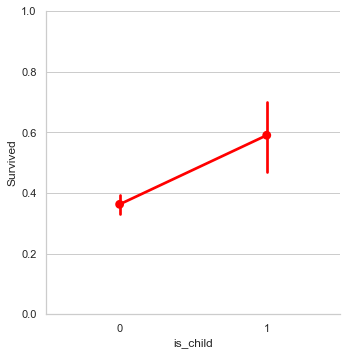

In [25]:
h = sns.PairGrid(data=titanic_train, x_vars=['is_child'], y_vars='Survived', height=5)
h.map(sns.pointplot, color="red")
h.set(ylim=(0, 1))
plt.show()

Children's survival rate is higher.

#### Converting categorical columns to dummy variables

In [26]:
titanic_train['is_female'] = titanic_train['Sex'].map({'male':0, 'female':1})

In [27]:
titanic_train = pd.get_dummies(titanic_train, columns=['Embarked'], prefix = 'is')

In [28]:
titanic_train.drop(columns = ['Parch','SibSp', 'Sex', 'family'], inplace = True)

In [29]:
titanic_train.head()

,Survived,Pclass,Age,Fare,is_alone,is_child,is_female,is_C,is_Q,is_S
0,0,3,22.0,7.2500,0,0,0,0,0,1
1,1,1,38.0,71.2833,0,0,1,1,0,0
2,1,3,26.0,7.9250,1,0,1,0,0,1
3,1,1,35.0,53.1000,0,0,1,0,0,1
4,0,3,35.0,8.0500,1,0,0,0,0,1


#### Analyzing the Target column

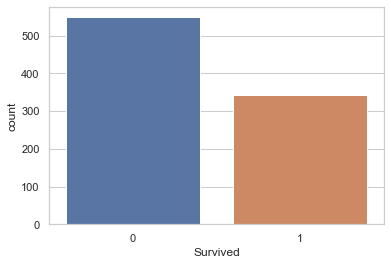

In [30]:
sns.countplot(x='Survived',data = titanic_train)
plt.show()

### Modeling

### Modeling

#### Splitting dataframe into target variable and feature set

In [31]:
X = titanic_train.iloc[:,1:]
y = titanic_train.iloc[:,0]

#### Splitting the 'feature set' and target variable into training and testing sets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,
                                                    test_size=0.2, random_state=0,
                                                    stratify = y)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 712 samples.
Testing set has 179 samples.


#### Function to train a model and return train and test accuracy

In [33]:
def train_predict(learner, X_train, y_train, X_test, y_test):
    
    results = {}
    
    # Fit the learner to the training data
    learner = learner.fit(X_train, y_train)
         
    # Get the predictions on the test set(X_test) and the training set(X_train)
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
    results['Model'] = learner.__class__.__name__
    
    # Compute accuracy on the training set
    results['Train Accuracy'] = round(accuracy_score(y_train, predictions_train),4)
        
    # Compute accuracy on test set
    results['Test Accuracy'] = round(accuracy_score(y_test, predictions_test),4)
    
    # Compute F-score on the training set
    results['Train F-score'] = round(fbeta_score(y_train, predictions_train, beta = 0.5),4)
        
    #Compute F-score on the test set
    results['Test F-score'] = round(fbeta_score(y_test, predictions_test, beta = 0.5),4)


    # Return the results
    return results

#### Initializing Models 

In [34]:
svc = SVC(random_state=100)
linearsvc = LinearSVC(random_state=100)
knn = KNeighborsClassifier()
dectree = DecisionTreeClassifier(random_state=100)
rforest = RandomForestClassifier(n_estimators = 100, random_state=100)
gnb = GaussianNB()
sgdc = SGDClassifier(random_state=100)
adaboost = AdaBoostClassifier(random_state = 100)
logreg = LogisticRegression(random_state=100)

#### Training the models and sorting by test accuracy

In [34]:
model_list = [svc, linearsvc, knn, dectree, rforest, gnb, sgdc, adaboost, logreg]
results = []

for model in model_list:
    results.append(train_predict(model, X_train, y_train, X_test, y_test))
    
model_df = pd.DataFrame(results, columns = ['Model','Train Accuracy','Test Accuracy','Train F-score',
                                            'Test F-score']).sort_values('Test F-score', ascending = False)

In [35]:
model_df

,Model,Train Accuracy,Test Accuracy,Train F-score,Test F-score
8,LogisticRegression,0.8020,0.7821,0.7486,0.7309
7,AdaBoostClassifier,0.8385,0.7765,0.7949,0.7165
4,RandomForestClassifier,0.9817,0.7765,0.9814,0.7143
3,DecisionTreeClassifier,0.9817,0.7654,0.9879,0.7029
5,GaussianNB,0.7374,0.7598,0.6612,0.7018
1,LinearSVC,0.6826,0.7039,0.5336,0.6051
2,KNeighborsClassifier,0.8076,0.6927,0.7548,0.5980
0,SVC,0.6952,0.6313,0.5864,0.4404
6,SGDClassifier,0.3792,0.3799,0.4312,0.4334


### Scaling Numerical Features

In [36]:
scaler = StandardScaler()
numerical = ['Pclass','Age','Fare']

titanic_train_scaled = pd.DataFrame(data = titanic_train)
titanic_train_scaled[numerical] = scaler.fit_transform(titanic_train[numerical])

In [37]:
titanic_train_scaled.head(2)

,Survived,Pclass,Age,Fare,is_alone,is_child,is_female,is_C,is_Q,is_S
0,0,0.827377,-0.581659,-0.502445,0,0,0,0,0,1
1,1,-1.566107,0.649327,0.786845,0,0,1,1,0,0


#### Rerunning the models with scaled numerical features

In [38]:
X = titanic_train_scaled.iloc[:,1:]
y = titanic_train_scaled.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,
                                                    test_size=0.2, random_state=0,
                                                    stratify = y)

model_list = [svc, linearsvc, knn, dectree, rforest, gnb, sgdc, adaboost, logreg]
results2 = []

for model in model_list:
    results2.append(train_predict(model, X_train, y_train, X_test, y_test))
    
model_df2 = pd.DataFrame(results2, columns = ['Model','Train Accuracy','Test Accuracy','Train F-score',
                                            'Test F-score']).sort_values('Test F-score', ascending = False)

In [39]:
model_df2

,Model,Train Accuracy,Test Accuracy,Train F-score,Test F-score
0,SVC,0.8329,0.7933,0.8149,0.7708
1,LinearSVC,0.7963,0.7989,0.7388,0.7541
8,LogisticRegression,0.7992,0.7933,0.7433,0.7443
4,RandomForestClassifier,0.9817,0.7821,0.9814,0.7231
2,KNeighborsClassifier,0.8610,0.7709,0.8276,0.7167
7,AdaBoostClassifier,0.8385,0.7765,0.7949,0.7165
3,DecisionTreeClassifier,0.9817,0.7654,0.9879,0.7029
5,GaussianNB,0.7374,0.7598,0.6612,0.7018
6,SGDClassifier,0.6503,0.6313,0.5478,0.5263


#### Since SVC is based on Eucledian distances and we have cateforical predictors, we will not use SVC. Next best model is, Logistic Regression as it has the next highest Test F-score

#### Hyperparameter tuning

In [40]:
# defining parameter range
param_grid =  {'penalty' : ['l2'],
               'solver' : ['lbfgs', 'liblinear', 'sag', 'saga'],
               'C': np.logspace(-4, 4, 20)}
  
grid = GridSearchCV(LogisticRegression(random_state=100), param_grid, refit = True, verbose = 3, n_jobs = -2)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(estimator=LogisticRegression(random_state=100), n_jobs=-2,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
             verbose=3)

In [41]:
# best parameter after tuning
print(grid.best_params_)
  
# how our model looks after hyper-parameter tuning?
print(grid.best_estimator_)

{'C': 1.623776739188721, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression(C=1.623776739188721, random_state=100)


In [42]:
predictions_test = grid.predict(X_test)
predictions_train = grid.predict(X_train)
print("Train Accuracy: " + str(round(accuracy_score(y_train, predictions_train),4)))
print("Test Accuracy: " + str(round(accuracy_score(y_test, predictions_test),4)))
print("Train F-score: " + str(round(fbeta_score(y_train, predictions_train, beta = 0.5),4)))
print("Test F-score: " + str(round(fbeta_score(y_test, predictions_test, beta = 0.5),4)))

Train Accuracy: 0.7992
Test Accuracy: 0.7933
Train F-score: 0.7433
Test F-score: 0.7443


#### Saving the pickle file

In [43]:
with open('tuned_classifier.pkl','wb') as f:
    pickle.dump(grid,f)

## Holdout Test set

In [37]:
titanic_test = pd.read_csv('Titanic Survival\\holdout_test.csv')

In [38]:
titanic_test.head(2)

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,NaN,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,NaN,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [39]:
titanic_test.shape

(418, 12)

#### Null percentage of columns

In [40]:
((titanic_test.isnull().sum()*100)/titanic_test.shape[0]).round(2)

Survived       100.00
PassengerId      0.00
Pclass           0.00
Name             0.00
Sex              0.00
Age             20.57
SibSp            0.00
Parch            0.00
Ticket           0.00
Fare             0.24
Cabin           78.23
Embarked         0.00
dtype: float64

#### There are 3 columns with missing values:
* Age
* Cabin
* Fare

### Handling Nulls

#### Imputing "Age" with mean

In [41]:
titanic_test['Age'].fillna(int(titanic_test['Age'].mean()), inplace=True)

#### Dropping column "Cabin" since it is ~77% null values

In [42]:
titanic_test.drop(columns = ['Cabin'], inplace = True)

#### Imputing "Fare" with mean

In [43]:
titanic_test['Fare'].fillna(int(titanic_test['Fare'].mean()), inplace=True)

#### Performing same operations as training set

In [44]:
titanic_test.drop(columns = ['Name','Ticket'], inplace = True)

In [45]:
titanic_test['family'] = titanic_test['SibSp'] + titanic_test['Parch']

In [46]:
titanic_test['is_alone'] = titanic_test['family'].apply(lambda x: 1 if x == 0 else 0)

In [47]:
titanic_test['is_child'] = titanic_test['Age'].apply(lambda x: 1 if x <= 15 else 0)

In [48]:
titanic_test['is_female'] = titanic_test['Sex'].map({'male':0, 'female':1})

In [49]:
titanic_test = pd.get_dummies(titanic_test, columns=['Embarked'], prefix = 'is')

In [50]:
titanic_test.drop(columns = ['Parch','SibSp', 'Sex', 'family'], inplace = True)

In [58]:
scaler = StandardScaler()
titanic_test_scaled = pd.DataFrame(data = titanic_test)
titanic_test_scaled[numerical] = scaler.fit_transform(titanic_test[numerical])

In [59]:
X_test_holdout = titanic_test_scaled.iloc[:,2:]

In [60]:
X_test_holdout.head(2)

,Pclass,Age,Fare,is_alone,is_child,is_female,is_C,is_Q,is_S
0,0.873482,0.339424,-0.498380,1,0,0,0,1,0
1,0.873482,1.329924,-0.513247,0,0,1,0,0,1


#### Loading the pickle file

In [61]:
with open('tuned_classifier.pkl', 'rb') as f:
    tuned_model = pickle.load(f)

#### Making Predictions

In [62]:
predictions = tuned_model.predict(X_test_holdout)

In [63]:
predict = pd.DataFrame({'PassengerId':titanic_test_scaled['PassengerId'],
                        'Survived':predictions})

In [64]:
predict.to_csv('Titanic results from Devdutt Sharma.csv', index = False)